In [67]:
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

TASK 1:

In [2]:
# Read the CSV file.
data = pd.read_csv("CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [3]:
dummyclassifier = DummyClassifier(strategy='most_frequent')

In [4]:
cross_val_score(dummyclassifier, Xtrain, Ytrain)

array([0.78235294, 0.78235294, 0.77941176, 0.77941176, 0.77941176])

Trying a basic Tree

In [5]:
decisiontree = DecisionTreeClassifier(random_state=0, criterion='gini', 
                                     splitter ='best')

In [6]:
cross_val_score(decisiontree, Xtrain, Ytrain)

array([0.91470588, 0.94117647, 0.91176471, 0.90588235, 0.94705882])

Random forest experiment

In [7]:
randomforest = RandomForestClassifier(max_depth=10, random_state=0)

In [8]:
cross_val_score(randomforest, Xtrain, Ytrain)

array([0.93235294, 0.95294118, 0.93529412, 0.92647059, 0.94411765])

Gradient boosting

In [9]:
gradientboosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                              max_depth=1, random_state=0).fit(Xtrain, Ytrain)

In [10]:
cross_val_score(gradientboosting, Xtrain, Ytrain)

array([0.90294118, 0.94117647, 0.9       , 0.91470588, 0.92647059])

Perceptron

In [11]:
perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(Xtrain, Ytrain)

Perceptron()

In [12]:
cross_val_score(perceptron, Xtrain, Ytrain)

array([0.84705882, 0.88529412, 0.82941176, 0.85294118, 0.71176471])

Logistic regression
Had to standardize, otherwise it wouldnt converge

In [13]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

logregression = LogisticRegression(random_state=0, max_iter=1000).fit(Xtrain_scaled, Ytrain)

In [14]:
cross_val_score(logregression, Xtrain_scaled, Ytrain)

array([0.89117647, 0.9       , 0.86764706, 0.89411765, 0.90588235])

In [15]:
svc = make_pipeline(StandardScaler(),LinearSVC(dual="auto", random_state=0, tol=1e-5))
svc.fit(Xtrain, Ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(dual='auto', random_state=0, tol=1e-05))])

In [16]:
cross_val_score(svc, Xtrain, Ytrain)

array([0.88529412, 0.90882353, 0.86176471, 0.89705882, 0.90294118])

In [17]:
mlp = MLPClassifier(random_state=1, max_iter=300).fit(Xtrain, Ytrain)

In [18]:
cross_val_score(mlp, Xtrain, Ytrain)

array([0.84117647, 0.82058824, 0.83529412, 0.90588235, 0.87647059])

In [19]:
decisiontree.fit(Xtrain, Ytrain)
Yguess = decisiontree.predict(Xtest)
print(accuracy_score(Ytest, Yguess))

0.9061032863849765


TASK 2:

In [20]:
import pandas as pd

data = pd.read_csv('iris.csv')
data_shuffled = data.sample(frac=1.0, random_state=0)
X = data_shuffled.drop('species', axis=1)
Y = data_shuffled['species']

In [21]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.4, random_state=0)

In [22]:
X2 = X[['petal_length', 'petal_width']]
Y_encoded = Y.replace({'setosa':0, 'versicolor':1, 'virginica':2})

In [23]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False
        
    def to_str(self, indent, lines, names):
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        lines.append(' '*indent + val_str)

In [24]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id
        
    def to_str(self, indent, lines, names):
        pad = ' '*indent
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lines.append(pad + f'{fname} <= {self.threshold:.3g}?')
        lines.append(pad + '  True =>')
        self.low_subtree.to_str(indent+4, lines, names)
        lines.append(pad + '  False =>')
        self.high_subtree.to_str(indent+4, lines, names)
        

In [25]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        
        _, best_feature, best_threshold = \
            max(self.best_split(X, Y, feature) 
                for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = \
            self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    def __str__(self):
        lines = []
        self.root.to_str(0, lines, self.names)
        return '\n'.join(lines)
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [26]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


In [27]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

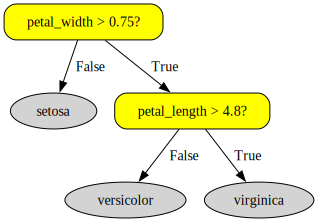

In [39]:
cls = TreeClassifier(max_depth=2)
cls.fit(Xtrain, Ytrain)
cls.draw_tree()

In [40]:
cross_val_score(cls, Xtrain, Ytrain)

array([0.88888889, 0.94444444, 0.94444444, 1.        , 1.        ])

In [41]:
predictions=cls.predict(Xtest)
print(predictions)

['virginica', 'virginica', 'virginica', 'setosa', 'versicolor', 'setosa', 'virginica', 'virginica', 'virginica', 'versicolor', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'virginica', 'setosa', 'virginica', 'versicolor', 'versicolor', 'virginica', 'versicolor', 'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'virginica', 'virginica', 'versicolor', 'versicolor', 'virginica', 'virginica', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'setosa', 'versicolor', 'setosa', 'virginica', 'versicolor', 'virginica', 'setosa', 'versicolor', 'versicolor', 'setosa', 'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'versicolor']


In [42]:
accuracy_score(Ytest, predictions)

0.9

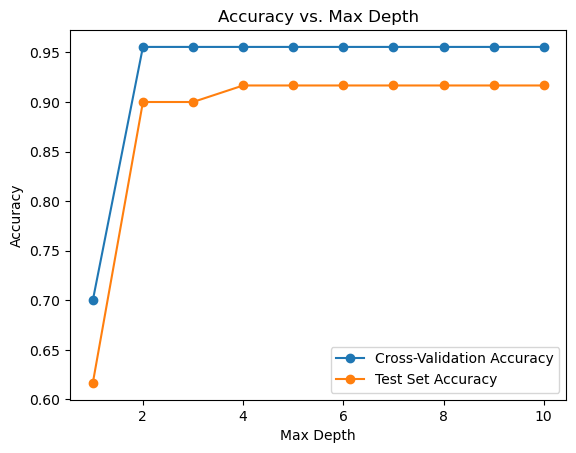

In [49]:
max_depths = range(1, 11)  # Adjust the range based on your requirements

# Lists to store results
depths = []
cv_accuracies = []
test_accuracies = []

# Loop through different max depths
for depth in max_depths:
    # Create and train the classifier
    cls = TreeClassifier(max_depth=depth)
    cls.fit(Xtrain, Ytrain)

    # Cross-validation score
    cv_score = np.mean(cross_val_score(cls, Xtrain, Ytrain, cv=5))
    
    # Predictions on the test set
    predictions = cls.predict(Xtest)
    
    # Accuracy on the test set
    test_accuracy = accuracy_score(Ytest, predictions)

    # Save results
    depths.append(depth)
    cv_accuracies.append(cv_score)
    test_accuracies.append(test_accuracy)

# Plot the results
plt.plot(depths, cv_accuracies, label='Cross-Validation Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Set Accuracy', marker='o')
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Task 3:

In [51]:
# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 7 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


In [54]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.00452185, 0.0040226 , 0.00329328, 0.00363493, 0.0032506 ]),
 'score_time': array([0.00231552, 0.00209141, 0.00201368, 0.00183558, 0.00180268]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

In [61]:
randomforest = RandomForestRegressor(max_depth=10, random_state=0)
randomforest.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=10, random_state=0)

In [62]:
cross_validate(randomforest, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([2.19591188, 2.12367105, 2.03668571, 2.11859679, 1.98996091]),
 'score_time': array([0.03694415, 0.03546953, 0.03719258, 0.03582644, 0.03568387]),
 'test_score': array([-0.27916833, -0.25042886, -0.26385433, -0.27309293, -0.26307047])}

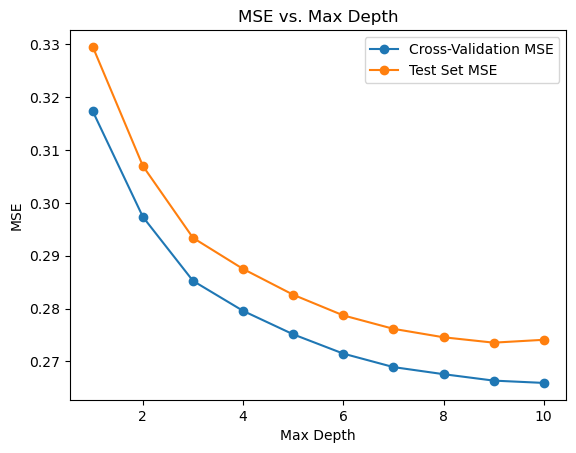

In [68]:
# Define a range of max depths to try
max_depths = range(1, 11)  # Adjust the range based on your requirements

# Lists to store results
depths = []
cv_mse = []
test_mse = []

# Loop through different max depths
for depth in max_depths:
    # Create and train the regressor
    regressor = RandomForestRegressor(max_depth=depth, random_state=0)
    regressor.fit(Xtrain, Ytrain)

    # Cross-validation MSE
    cv_mse_score = -np.mean(cross_val_score(regressor, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error'))
    
    # Predictions on the test set
    predictions = regressor.predict(Xtest)
    
    # MSE on the test set
    test_mse_score = mean_squared_error(Ytest, predictions)

    # Save results
    depths.append(depth)
    cv_mse.append(cv_mse_score)
    test_mse.append(test_mse_score)

# Plot the results
plt.plot(depths, cv_mse, label='Cross-Validation MSE', marker='o')
plt.plot(depths, test_mse, label='Test Set MSE', marker='o')
plt.title('MSE vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error
  
randomforest.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, randomforest.predict(Xtest))

0.2740850405500036